## `Named Entity Recognition (NER)`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf

np.random.seed(45)
tf.random.set_seed(45)
plt.style.use("ggplot")

* `Load the Dataset`

In [2]:
df = pd.read_csv('./ner_dataset.csv', encoding='latin1')
df = df.fillna(method='ffill')
df.head(20)

<ipython-input-2-6c84ed17a29a>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
# Check uinuqe in Tag column
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [4]:
print('Unique words in corpus:', df['Word'].nunique())
print('Unique tags in corpus:', df['Tag'].nunique())

Unique words in corpus: 9216
Unique tags in corpus: 17


In [5]:
# Get unique words in corpus to a list to be tokenized
words = df['Word'].unique().tolist()

# 'ENDPAD' make that word for padding shorter sequences # use later for padding
words.append('ENDPAD')

# Length of unique words in corpus
num_words = len(words)
num_words

9217

In [6]:
# Get unique tags in the corpus to a list
tags = df['Tag'].unique().tolist()

# Length of unique tags in corpus
num_tags = len(tags)
num_tags

17

In [7]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [9]:
# Let's test on some samples -- 1st sentence
df_test = df.iloc[:50]

# Aggregation function for looping over the (Word, POS, Tag)
agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                  s['POS'].values.tolist(),
                                                  s['Tag'].values.tolist())]


grouped = df_test.groupby('Sentence #').apply(agg_func)
grouped


,0
Sentence #,
Sentence: 1,"[(Thousands, NNS, O), (of, IN, O), (demonstrat..."
Sentence: 2,"[(Families, NNS, O), (of, IN, O), (soldiers, N..."


* `Retrieve Sentences and Corresponsing Tags`

In [10]:
sentences = [s for s in grouped]
grouped['Sentence: 1']

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [11]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data

        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                           s['POS'].values.tolist(),
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[f"Sentence: {self.n_sent}"]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(df)
sentences = getter.sentences

* `Mapping between Sentences and Tags`

In [12]:
# Indexing words and tags tokenization
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

* `Padding Sentences`

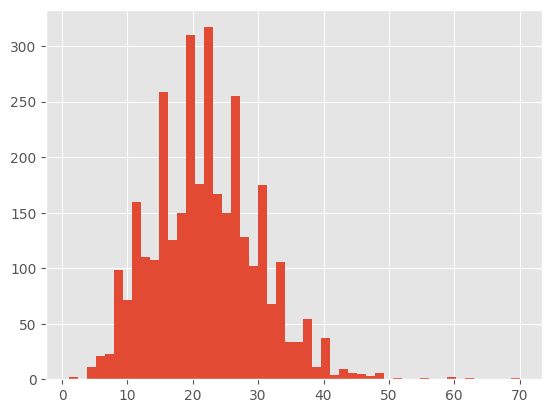

In [13]:
# Histogram represening the length of each sentences
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [41]:
# config
MAX_SEQUENCE_LENGTH = 50
EMBED_SIZE = 100
VOCAB_SIZE = num_words
NUM_OUTPUTS = num_tags
BATCH_SIZE = 32
EPOCHS = 3

In [42]:
# Indexing each word in each sentence (nested loop), for both words (X - Features), and tags (y - target)
X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[2]] for w in s] for s in sentences]

# padding
X = tf.keras.preprocessing.sequence.pad_sequences(sequences=X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', value=word2idx['ENDPAD'])  # words (X - Features)
y = tf.keras.preprocessing.sequence.pad_sequences(sequences=y, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', value=tag2idx['O'])  # tags (y - target)

In [43]:
X[0] #tokens

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   10,   16,    2,   17,   18,   19,   20,
         21,   22, 9217, 9217, 9217, 9217, 9217, 9217, 9217, 9217, 9217,
       9217, 9217, 9217, 9217, 9217, 9217, 9217, 9217, 9217, 9217, 9217,
       9217, 9217, 9217, 9217, 9217, 9217], dtype=int32)

In [44]:
y[0] #tag --> token 1 id 0, token 7 id 1

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [45]:
sentences[0] # 6 london

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [46]:
tag2idx # 1 geo

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

* `Split Dataset`

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45, shuffle=True)

In [48]:
y  # In Target (tags) : the first value in the second row (2)

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [0, 0, 7, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [49]:
tag2idx   # see what (2) refer in tags (B-gpe) --> (Geopolitical Entity)

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [50]:
X  # In Features (words) : the first value in the second row (125)

array([[   1,    2,    3, ..., 9217, 9217, 9217],
       [ 125,  126,  127, ..., 9217, 9217, 9217],
       [ 943,  944,  364, ..., 9217, 9217, 9217],
       ...,
       [  62, 4629,   60, ..., 9217, 9217, 9217],
       [   1,    2, 4639, ..., 9217, 9217, 9217],
       [2809,    2,   53, ..., 9217, 9217, 9217]], dtype=int32)

In [51]:
{v: k for k, v in word2idx.items()}.get(125)  # pop out to see what 125 refer to what word ?

'Iranian'

----

* `Model`

In [52]:
model = tf.keras.models.Sequential([
    # RNN base
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)), # many to many task
# wrong func if i just use dense each timestamp return prediction not 1 vector

    # FC applied to each timestep ######################
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(NUM_OUTPUTS, activation='softmax'))
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [53]:
model.compile(loss='sparse_categorical_crossentropy', # categorical target matrix one hot (i am not use ohe), vector not ohe sparse
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
chkpt = tf.keras.callbacks.ModelCheckpoint('model_weights.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# fit
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping, chkpt])

Epoch 1/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.8836 - loss: 0.5970 - val_accuracy: 0.9538 - val_loss: 0.1514
Epoch 2/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9599 - loss: 0.1322 - val_accuracy: 0.9699 - val_loss: 0.1151
Epoch 3/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9758 - loss: 0.0829 - val_accuracy: 0.9736 - val_loss: 0.1083


In [54]:
# evaluate on test
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9748 - loss: 0.0996
Test Loss: 0.10831885784864426
Test Accuracy: 0.9735758304595947


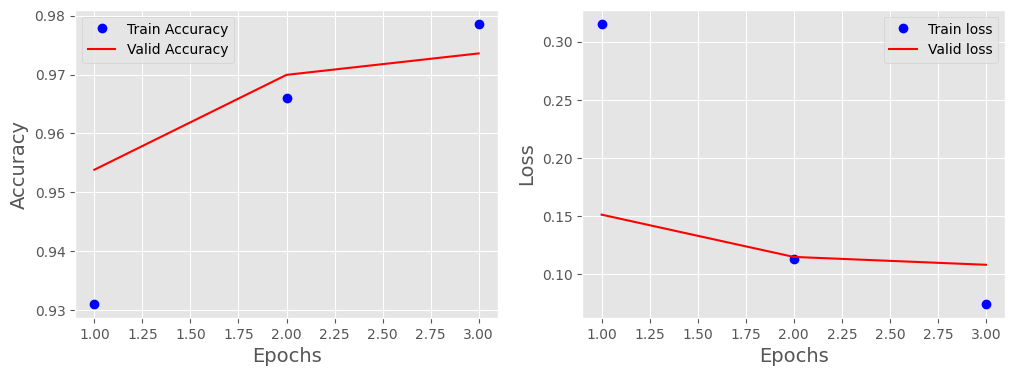

In [55]:
## Visualize the resutls
fia, ax = plt.subplots(1, 2, figsize=(12, 4))
n_epochs = len(history.history['loss'])  # real number of epochs in history, as we made early stopp
plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

In [56]:
import os
os.makedirs('ner-files', exist_ok=True)

In [57]:
joblib.dump(word2idx, 'ner-files/word2idx.joblib', compress=9)  # save word2idx & tag2idx
joblib.dump(tag2idx, 'ner-files/tag2idx.joblib', compress=9)

['ner-files/tag2idx.joblib']

In [58]:
model.save("ner-files/ner-model.h5") # save model

----

* `Load Trained Model`

In [59]:
# Load model, word2idx, and tag2idx
model = tf.keras.models.load_model('ner-files/ner-model.h5')
word2idx = joblib.load('ner-files/word2idx.joblib')
tag2idx = joblib.load('ner-files/tag2idx.joblib')

In [60]:
# From index to tag
idx2tag = {v:k for k, v in tag2idx.items()}

In [61]:
def inference(text: str):

    # Preprocess the input text
    X_new = [[word2idx.get(w, 0) for w in text.split()]]
    X_new_padded = tf.keras.preprocessing.sequence.pad_sequences(sequences=X_new,
                                                                 maxlen=MAX_SEQUENCE_LENGTH,
                                                                 padding='post',
                                                                 truncating='post',
                                                                 value=word2idx['ENDPAD'])
    # Predict tags
    predictions = model.predict(np.array([X_new_padded[0]]))
    predictions = np.argmax(predictions, axis=-1)[0]  # list of list

    # Map predictions back to tags
    predicted_tags = [idx2tag.get(idx, 'O') for idx in predictions]

    # Create a dictionary of word to predicted tag
    word_tag_pairs = dict(zip(text.split(), predicted_tags))

    return word_tag_pairs

In [62]:
text = 'this is Cairo from Egypt' # Test sample
inference(text=text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


{'this': 'O', 'is': 'O', 'Cairo': 'B-geo', 'from': 'O', 'Egypt': 'O'}

---

In [63]:
from google.colab import files
files.download('/content/ner-files')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>